The following code conducts research on a topic and the search queries are provided by the default planner of deep agent. Research is a classic example of benefitting from multiple parallel subagent runs to research on multiple sub topics before coming together to converge and collate. The model used here is Azure GPT5 and a filesystem backend has been added.

In [1]:
from tavily import TavilyClient
from deepagents import create_deep_agent
import os
from typing import Literal
from langchain_mistralai import ChatMistralAI
from deepagents.backends import FilesystemBackend
from langchain_community.tools.file_management import (
    WriteFileTool,
    ReadFileTool,
    ListDirectoryTool
)
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in .env file")

In [2]:
tavily_client = TavilyClient(TAVILY_API_KEY)


In [11]:
def internet_search(query: str, 
            topic: Literal["general", "news", "finance"] = "general",
            max_results: int = 5,
            include_raw_content:bool = False):
    """Run a web search"""  
    response = tavily_client.search(query,max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic) 
    return response


In [32]:
instructions = """You are an experta and short researcher. Your job is to do a thorough research and publish a short report.

## Available Tools:

1. 'internet_search' - Use this to search the internet for information
   - Parameters: query (str), topic (general/news/finance), max_results (int), include_raw_content (bool)

2. 'write_file' - Use this to write content to a file in the storage directory
   - Parameters: file_path (str), text (str)
   - Example: write_file(file_path="report.md", text="# My Report\\n\\nContent here...")

3. 'read_file' - Use this to read files you've previously written
   - Parameters: file_path (str)

4. 'list_files' - Use this to list files in the storage directory

## Your Research Process:

1. Use 'internet_search' tool to gather information about the topic
2. Take notes and organize the information
3. **IMPORTANT**: Use 'write_file' tool to save a notes.md file with your research findings
4. Create a comprehensive report based on your research
5. **IMPORTANT**: Use 'write_file' tool to save the final report as report.md

## Critical Rules:
- You MUST call the 'write_file' tool to save both notes.md and report.md
- File paths should be simple names like "notes.md" or "report.md" (not full paths)
- Always create tangible files - your research must be saved to disk
- After writing files, you can use 'list_files' to verify they were created

Example workflow:
1. internet_search(query="topic details", max_results=5)
2. write_file(file_path="notes.md", text="## Research Notes\\n...")
3. write_file(file_path="report.md", text="# Final Report\\n...")
"""

In [33]:
MISTRALAI_API_KEY = os.getenv("MISTRALAI_API_KEY")
if not MISTRALAI_API_KEY:
    raise ValueError("MISTRALAI_API_KEY not found in .env file")

os.environ["MISTRALAI_API_KEY"] = MISTRALAI_API_KEY

In [34]:

model = ChatMistralAI(
    model="mistral-large-latest",
    api_key= MISTRALAI_API_KEY,
    temperature=0,
    max_retries=2,
    max_tokens=2000
    # other params...
) 

In [ ]:
from pathlib import Path


path = Path("./storage")
path.mkdir(parents=True, exist_ok=True)

write_file = WriteFileTool(root_dir=str(path))
read_file = ReadFileTool(root_dir=str(path))
list_files = ListDirectoryTool(root_dir=str(path))

deep_agent = create_deep_agent(
    # Finally found : FileSystemBackend not gonna create files
    # backend=FilesystemBackend(root_dir=str(path)),
    model=model,
    tools = [internet_search, write_file, read_file, list_files],
    system_prompt=instructions
)  

### Prompt

{'messages': [HumanMessage(content='What is RGB in LED displays ?. ', additional_kwargs={}, response_metadata={}, id='1e70b67b-4fee-4e59-b12d-8cf18d221c98'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'FHR5AtHVu', 'function': {'name': 'internet_search', 'arguments': '{"query": "What is RGB in LED displays?", "max_results": 5, "include_raw_content": true}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 5154, 'total_tokens': 5185, 'completion_tokens': 31}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, id='lc_run--019bbe19-2d3c-7ff3-8a2f-8a7db66b43a1-0', tool_calls=[{'name': 'internet_search', 'args': {'query': 'What is RGB in LED displays?', 'max_results': 5, 'include_raw_content': True}, 'id': 'FHR5AtHVu', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 5154, 'output_tokens': 31, 'total_tokens': 5185}), ToolMessage(content='{"que
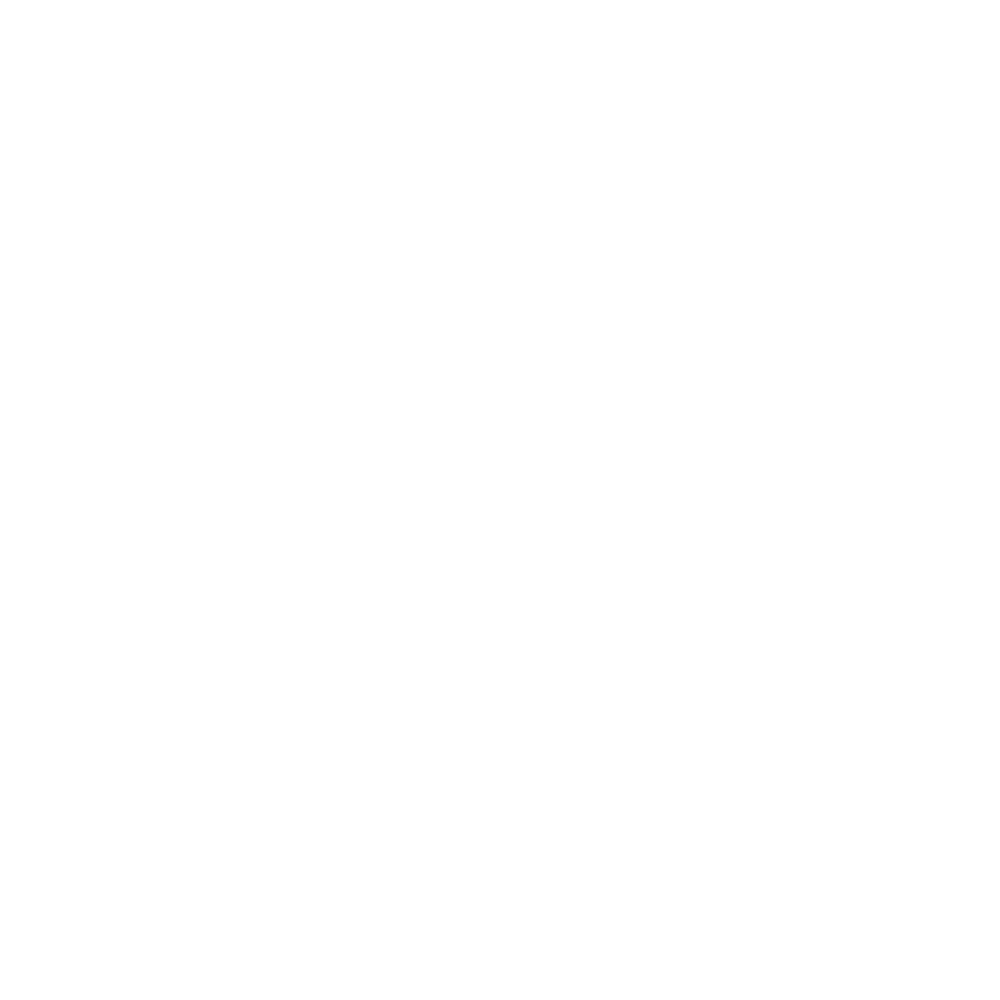
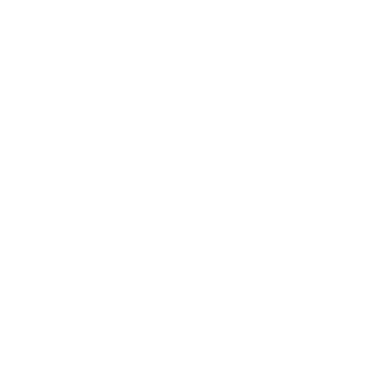
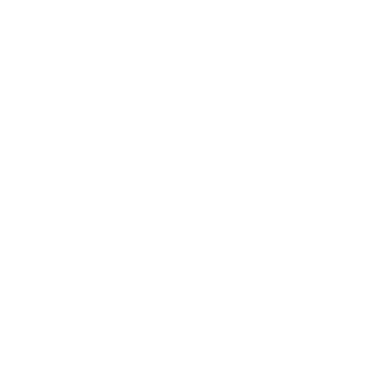
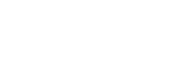
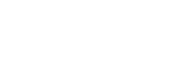
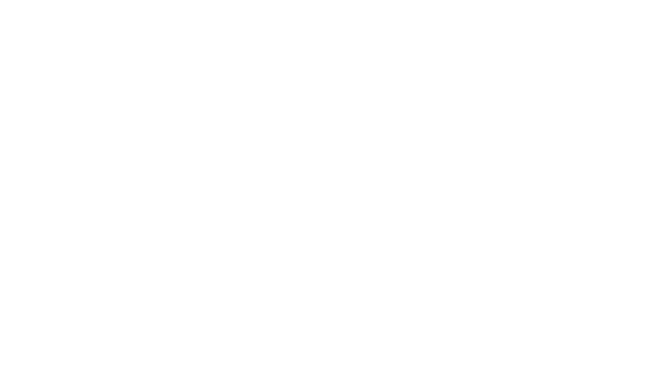
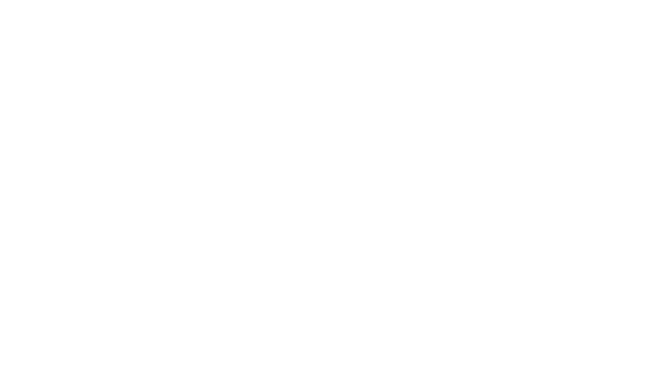
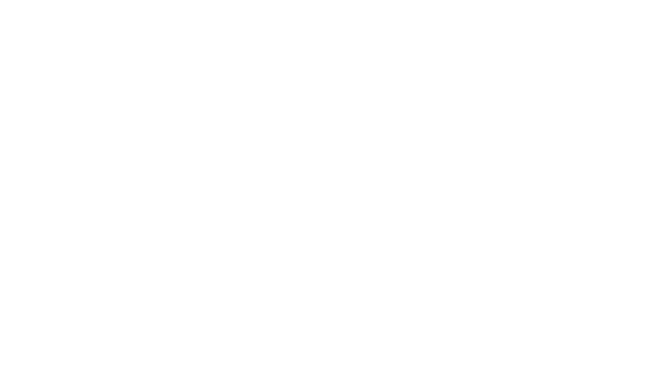
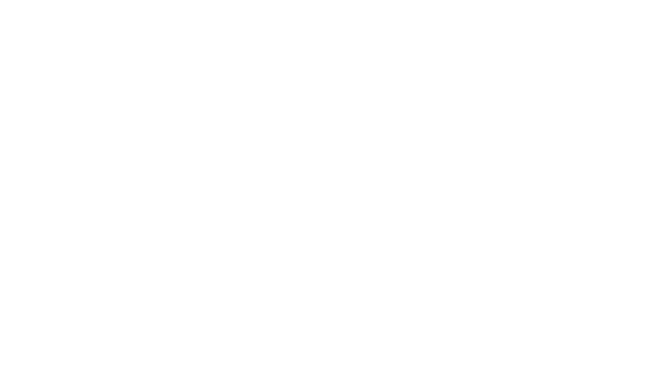
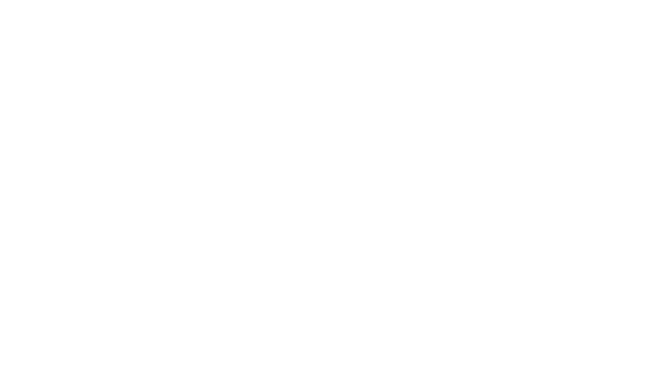
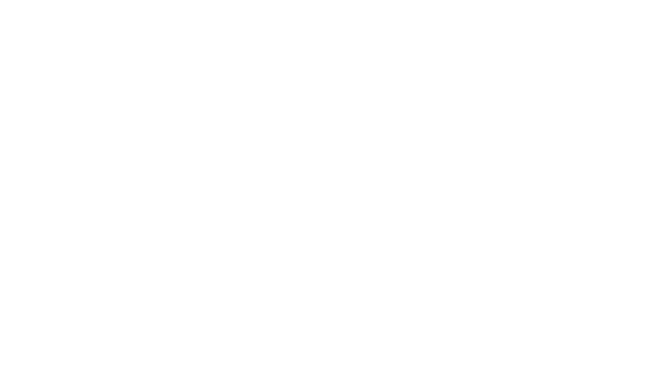
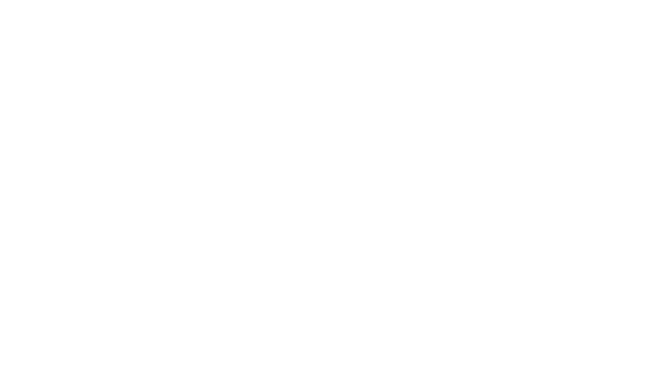
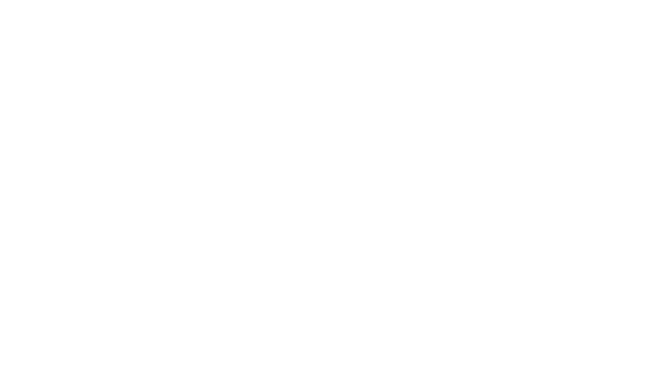
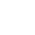
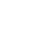
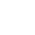
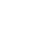
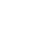

In [36]:
# response = deep_agent.invoke({"messages": [{"role": "user", "content": "What are all the latest additions to Langchain"}]})
response = deep_agent.invoke({
    "messages": [
        {
            "role": "user",
            "content": (
                "What is RGB in LED displays ?. "
            )
        }
    ]
})

print(response)

In [19]:
response.keys()

dict_keys(['messages'])

In [31]:
response['messages']

[HumanMessage(content='Here is a summary of the conversation to date:\n\n### **Extracted Context: Iran\'s Current Issues (2024-2025)**\n\n#### **Political Situation**\n- **Government Structure**: Hybrid system with ultimate authority under Supreme Leader Ayatollah Ali Khamenei. Hardline conservatives dominate, limiting reformist influence.\n- **Leadership**: President Masoud Pezeshkian (elected July 2024) is a moderate but constrained by the Supreme Leader. The Guardian Council (hardline-controlled) vets all candidates.\n- **Protests & Repression**:\n  - "Woman, Life, Freedom" protests (2022–2024) continue, focused on economic hardship, political repression, and women’s rights (e.g., mandatory hijab laws).\n  - Security forces respond with violent crackdowns, arrests, executions, and internet blackouts. Facial recognition used to enforce hijab laws.\n- **Regional Relations**:\n  - Supports proxy groups (Hezbollah, Hamas, Iraqi/Yemeni militias) but faces setbacks (e.g., Hezbollah weaken